# Save Model

## Goal

* How to save trained model
* How to import trained models

In [ ]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

/tmp/ipython-input-3443976982.py:11: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


## Import and process the data

In [ ]:
data = np.loadtxt('/content/sample_data/mnist_train_small.csv', delimiter = ',')

labels = data[:,0]
data = data[:,1:]

data_norm = data / np.max(data)

dataT = torch.tensor(data_norm).float()
labelsT = torch.tensor(labels).long()

dataT, labelsT

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([6, 5, 7,  ..., 2, 9, 5]))

## Split

In [ ]:
train_data, test_data, train_labels, test_labels = train_test_split(dataT, labelsT, test_size = .2)

train_dataset = TensorDataset(train_data, train_labels)
test_dataset = TensorDataset(test_data, test_labels)

batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = test_data.shape[0])

## Model

In [ ]:
def ModelCreate():
  class ModelArch(nn.Module):
    def __init__(self):
      super().__init__()

      self.input = nn.Linear(784, 128)
      self.f1 = nn.Linear(128, 64)
      self.f2 = nn.Linear(64, 64)
      self.output = nn.Linear(64, 10)

    def forward(self, x):
      x = F.relu(self.input(x))
      x = F.relu(self.f1(x))
      x = F.relu(self.f2(x))
      x = self.output(x)
      return x

  ann = ModelArch()
  loss_fn = nn.CrossEntropyLoss()
  optim = torch.optim.SGD(ann.parameters(), lr = 1e-3)

  return ann, loss_fn, optim

In [ ]:
ann, loss_fn, optimizer = ModelCreate()
X, y = next(iter(train_dataloader))
y_hat = ann(X)
loss = loss_fn(y_hat, y)
loss

tensor(2.3143, grad_fn=<NllLossBackward0>)

## Train

In [ ]:
def ModelTrain(epochs, verbose):
  net, loss_fn, optimizer = ModelCreate()

  losses = torch.zeros(epochs)
  train_accs = []
  test_accs = []

  for epoch in range(epochs):
    net.train()

    batch_acc = []
    batch_loss = []

    for X, y in train_dataloader:

      y_hat = net(X)
      loss = loss_fn(y_hat, y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batch_loss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(y_hat, axis = 1) == y
      matches_numeric = matches.float()
      accuracy_pct = 100 * torch.mean(matches_numeric)
      batch_acc.append(accuracy_pct)
    # end of batch loop

    #training accuracy
    train_acc = np.mean(batch_acc)
    train_accs.append(train_acc)

    # and get  avg losses
    losses[epoch] = np.mean(batch_loss)

    # test accuracy
    net.eval()
    X, y = next(iter(test_dataloader))
    with torch.no_grad(): # deactivates autograd
      y_hat = net(X)

    test_acc = 100 * torch.mean((torch.argmax(y_hat, axis = 1) == y).float())
    test_accs.append(test_acc)
  # end epochs

    if verbose and epoch%10 == 0:
      print(f'Epoch: {epoch} | Train Acc: {train_acc:.2f} | Test Acc: {test_acc:.2f} | Loss: {losses[epoch]:.2f}')

  return train_accs, test_accs, losses, net

In [ ]:
train_accs, test_accs, losses, ann = ModelTrain(epochs = 200, verbose = True)

Epoch: 0 | Train Acc: 10.26 | Test Acc: 9.48 | Loss: 2.30
Epoch: 10 | Train Acc: 20.69 | Test Acc: 21.70 | Loss: 2.29
Epoch: 20 | Train Acc: 26.66 | Test Acc: 27.40 | Loss: 2.28
Epoch: 30 | Train Acc: 42.21 | Test Acc: 43.45 | Loss: 2.24
Epoch: 40 | Train Acc: 33.73 | Test Acc: 35.15 | Loss: 2.10
Epoch: 50 | Train Acc: 47.83 | Test Acc: 50.95 | Loss: 1.69
Epoch: 60 | Train Acc: 67.35 | Test Acc: 67.68 | Loss: 1.15
Epoch: 70 | Train Acc: 76.61 | Test Acc: 76.00 | Loss: 0.79
Epoch: 80 | Train Acc: 82.00 | Test Acc: 81.67 | Loss: 0.62
Epoch: 90 | Train Acc: 85.01 | Test Acc: 84.93 | Loss: 0.52
Epoch: 100 | Train Acc: 86.51 | Test Acc: 86.58 | Loss: 0.47
Epoch: 110 | Train Acc: 87.46 | Test Acc: 87.62 | Loss: 0.43
Epoch: 120 | Train Acc: 88.19 | Test Acc: 88.38 | Loss: 0.41
Epoch: 130 | Train Acc: 88.72 | Test Acc: 88.65 | Loss: 0.38
Epoch: 140 | Train Acc: 89.32 | Test Acc: 89.12 | Loss: 0.37
Epoch: 150 | Train Acc: 89.76 | Test Acc: 89.50 | Loss: 0.35
Epoch: 160 | Train Acc: 90.20 | Test

## Plot

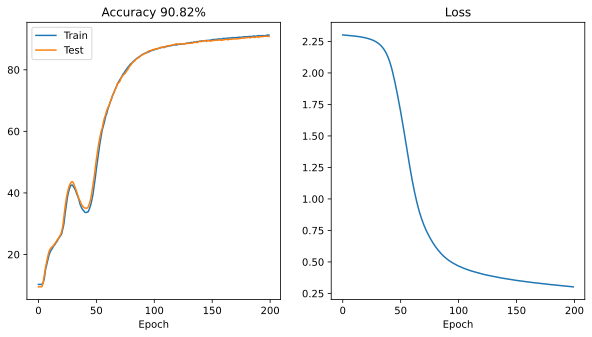

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(10,5))

ax[0].plot(train_accs)
ax[0].plot(test_accs)
ax[0].legend(['Train', 'Test'])
ax[0].set_title(f'Accuracy {test_accs[-1]:.2f}%')

ax[1].plot(losses)
ax[1].set_title('Loss')

for i in range(2):
  ax[i].set_xlabel('Epoch')

plt.show()

## Save trained model

## Load Model

In [ ]:
torch.save(ann.state_dict(), 'trainedModel.pt')

In [ ]:
model1 = ModelCreate()[0]
model2 = ModelCreate()[0]

model1.load_state_dict(torch.load('trainedModel.pt'))
model1

ModelArch(
  (input): Linear(in_features=784, out_features=128, bias=True)
  (f1): Linear(in_features=128, out_features=64, bias=True)
  (f2): Linear(in_features=64, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=10, bias=True)
)

## Compare

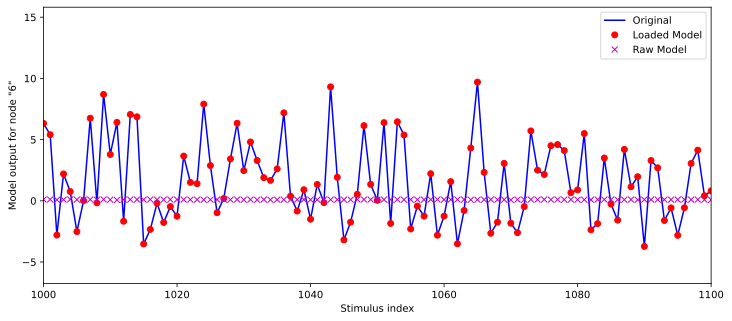

In [ ]:
X, y = next(iter(test_dataloader))

# run the data through both models

# raw model
# net = ModelCreate()[0]
y_hat_net = ann(X)
y_hat_model1 = model1(X)
y_hat_model2 = model2(X)

fig = plt.figure(figsize=(12,5))
plt.plot(y_hat_net[:,5].detach(), 'b', label = 'Original')
plt.plot(y_hat_model1[:,5].detach(), 'ro', label='Loaded Model')
plt.plot(y_hat_model2[:,5].detach(), 'mx', label='Raw Model')
plt.legend()
plt.xlabel('Stimulus index')
plt.ylabel('Model output for node "6"')
plt.xlim([1000,1100])
plt.show()

* Original - This is our model previous to save and load, saved in ann variable
* Loaded Model - This is model1, so raw model BUT aftewards we used load_state_dict() to update this model with trained weights
* Raw Model - this is completely raw model without any weight updates and training

# Save Best Performing Model

## Goal

* How to record the best of the models we created and trained
* How to avoid overfitting when saving the best devset model

Rationale

* Each epoch is a "different" model (the weights differ)
* The later models will be better than the earlier mdoels
* But there is no guarantee that the final model is the best!

We will

* Train a model
* Track performance inside the loop over training epochs
* Save (and export) the model state that maximizes devset accuracy
* Evaluate that model on the separate TEST set

## Libs

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import numpy as np
import copy

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

/tmp/ipython-input-3676305649.py:12: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


## Saving Highest Random Number

In [ ]:
the_best = [0,0]

for i in range(100):

  accuracy = np.random.rand()

  if accuracy > the_best[0]:
    the_best = [accuracy, i]

print(f'Highest accuracy was {100*the_best[0]:.2f}% in run {the_best[1]+1}.')

Highest accuracy was 99.66% in run 65.


## Create and inspect the data

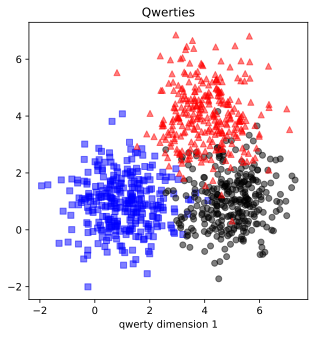

In [ ]:
n_per_clust = 300
blur = 1

A = [1,1]
B = [5,1]
C = [4,4]

a = [A[0] + np.random.randn(n_per_clust) * blur, A[1] + np.random.randn(n_per_clust) * blur]
b = [B[0] + np.random.randn(n_per_clust) * blur, B[1] + np.random.randn(n_per_clust) * blur]
c = [C[0] + np.random.randn(n_per_clust) * blur, C[1] + np.random.randn(n_per_clust) * blur]

data = np.hstack((
    a,b,c
)).T

labels = np.hstack((
    np.zeros(n_per_clust),
    np.ones(n_per_clust),
    np.ones(n_per_clust) + 1
))

data = torch.tensor(data).float()
labels = torch.tensor(labels).long()

# show data
fig = plt.figure(figsize = (5,5))
plt.plot(data[np.where(labels==0)[0], 0],data[np.where(labels==0)[0],1], 'bs', alpha = .5)
plt.plot(data[np.where(labels==1)[0], 0],data[np.where(labels==1)[0],1], 'ko', alpha = .5)
plt.plot(data[np.where(labels==2)[0], 0],data[np.where(labels==2)[0],1], 'r^', alpha = .5)
plt.title('Qwerties')
plt.xlabel('qwerty dimension 1')
plt.show()

## Split

In [ ]:
# specify sizes of the partitions
# order is train, devset, test
partitions = [3*n_per_clust-400, 200, 200]

# split th data
train_data, devtest_data, train_labels, devtest_labels = train_test_split(data, labels, train_size = partitions[0])

# split the devtest data
dev_data, test_data, dev_labels, test_labels = train_test_split(devtest_data, devtest_labels, train_size=partitions[1])

# print out the sizes
print('Total data size: ' + str(data.shape) + '\n')
print('Training data size: ' + str(train_data.shape))
print('Devset data size: ' + str(dev_data.shape))
print('Test data size: ' + str(test_data.shape))

Total data size: torch.Size([900, 2])

Training data size: torch.Size([500, 2])
Devset data size: torch.Size([200, 2])
Test data size: torch.Size([200, 2])


In [ ]:
# convert them into PyTorch Datasets (note: already converted to tensors)
train_dataset = TensorDataset(train_data, train_labels)
dev_dataset = TensorDataset(dev_data, dev_labels)
test_dataset = TensorDataset(test_data, test_labels)

# finally, translate into dataloader objects
batch_size = 30
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, drop_last = True)
dev_dataloader = DataLoader(dev_dataset, batch_size = dev_data.shape[0])
test_dataloader = DataLoader(test_dataset, batch_size = test_data.shape[0])

## Model

In [ ]:
def ModelCreate():
  class ModelArch(nn.Module):
    def __init__(self):
      super().__init__()

      self.input = nn.Linear(2, 8)
      self.f1 = nn.Linear(8, 16)
      self.f2 = nn.Linear(16, 16)
      self.output = nn.Linear(16, 3)

    def forward(self, x):
      x = F.relu(self.input(x))
      x = F.relu(self.f1(x))
      x = F.relu(self.f2(x))
      x = self.output(x)
      return x

  ann = ModelArch()
  loss_fn = nn.CrossEntropyLoss()
  optim = torch.optim.SGD(ann.parameters(), lr = 1e-3)

  return ann, loss_fn, optim

In [ ]:
ann, loss_fn, optimizer = ModelCreate()
X, y = next(iter(train_dataloader))
y_hat = ann(X)
loss = loss_fn(y_hat, y)
loss

tensor(1.0563, grad_fn=<NllLossBackward0>)

## Train with Save Best

In [ ]:
def ModelTrain(epochs, verbose):
  net, loss_fn, optimizer = ModelCreate()

  ### INITIALIZE A DICTIONARY FOR THE BEST MODEL ###
  the_best_model = {'accuracy':0, 'epoch':0, 'net':None}
  ##################################################

  losses = torch.zeros(epochs)
  train_accs = []
  test_accs = []

  for epoch in range(epochs):
    net.train()

    batch_acc = []
    batch_loss = []

    for X, y in train_dataloader:

      y_hat = net(X)
      loss = loss_fn(y_hat, y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batch_loss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(y_hat, axis = 1) == y
      matches_numeric = matches.float()
      accuracy_pct = 100 * torch.mean(matches_numeric)
      batch_acc.append(accuracy_pct)
    # end of batch loop

    #training accuracy
    train_acc = np.mean(batch_acc)
    train_accs.append(train_acc)

    # and get  avg losses
    losses[epoch] = np.mean(batch_loss)

    # test accuracy
    net.eval()
    X, y = next(iter(dev_dataloader))
    with torch.no_grad(): # deactivates autograd
      y_hat = net(X)

    test_acc = 100 * torch.mean((torch.argmax(y_hat, axis = 1) == y).float())
    test_accs.append(test_acc.item())
    ############ BEST ACC UPDATE #####################################
    if test_acc > the_best_model['accuracy']:
      the_best_model['accuracy'] = test_acc.item()
      the_best_model['epoch'] = epoch
      the_best_model['net'] = copy.deepcopy(net.state_dict())
    ###################################################################

  # end epochs

    if verbose and epoch%10 == 0:
      print(f'Epoch: {epoch} | Train Acc: {train_acc:.2f} | Test Acc: {test_acc:.2f} | Loss: {losses[epoch]:.2f}')

  return train_accs, test_accs, losses, net, the_best_model

In [ ]:
train_accs, dev_accs, losses, net, the_best_model = ModelTrain(epochs = 1000, verbose = True)

Epoch: 0 | Train Acc: 36.25 | Test Acc: 31.50 | Loss: 1.12
Epoch: 10 | Train Acc: 35.42 | Test Acc: 31.50 | Loss: 1.10
Epoch: 20 | Train Acc: 35.42 | Test Acc: 31.50 | Loss: 1.09
Epoch: 30 | Train Acc: 36.25 | Test Acc: 31.50 | Loss: 1.07
Epoch: 40 | Train Acc: 36.04 | Test Acc: 31.50 | Loss: 1.06
Epoch: 50 | Train Acc: 35.42 | Test Acc: 32.50 | Loss: 1.05
Epoch: 60 | Train Acc: 41.04 | Test Acc: 40.50 | Loss: 1.04
Epoch: 70 | Train Acc: 47.29 | Test Acc: 46.00 | Loss: 1.03
Epoch: 80 | Train Acc: 50.62 | Test Acc: 51.50 | Loss: 1.01
Epoch: 90 | Train Acc: 54.58 | Test Acc: 54.00 | Loss: 1.00
Epoch: 100 | Train Acc: 56.46 | Test Acc: 56.00 | Loss: 0.98
Epoch: 110 | Train Acc: 60.21 | Test Acc: 60.50 | Loss: 0.96
Epoch: 120 | Train Acc: 64.38 | Test Acc: 66.50 | Loss: 0.94
Epoch: 130 | Train Acc: 68.54 | Test Acc: 72.00 | Loss: 0.92
Epoch: 140 | Train Acc: 74.38 | Test Acc: 79.00 | Loss: 0.89
Epoch: 150 | Train Acc: 78.12 | Test Acc: 81.00 | Loss: 0.86
Epoch: 160 | Train Acc: 79.38 | Tes

In [ ]:
print(f'Best accuracy: {the_best_model['accuracy']:.2f}% at Epoch {the_best_model['epoch']}.')

Best accuracy: 94.00% at Epoch 608.


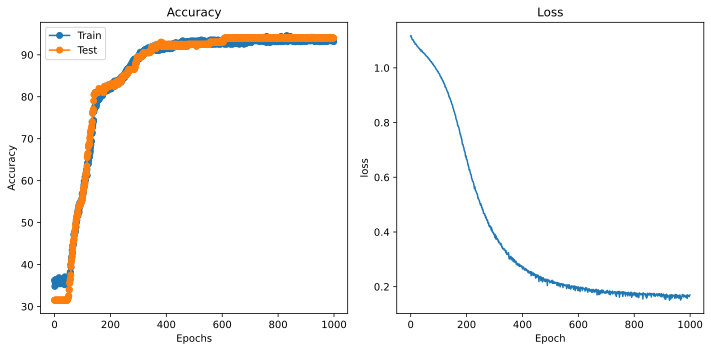

In [ ]:
fig, ax = plt.subplots(1,2,figsize = (10,5))

ax[0].plot(train_accs, '-o')
ax[0].plot(dev_accs, '-o')
ax[0].legend(['Train', 'Test'])
ax[0].set_title('Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
# ax[0].set_ylim([93,98])
# ax[0].set_xlim([900,1000])

ax[1].plot(losses)
ax[1].set_ylabel('loss')
ax[1].set_xlabel('Epoch')
ax[1].set_title('Loss')

plt.tight_layout()
plt.show()

## Test

In [ ]:


model_best = ModelCreate()[0]
model_best.load_state_dict(the_best_model['net'])
X_test, y_test = next(iter(test_dataloader))

final_y_hat = net(X_test)
final_loss = loss_fn(final_y_hat, y_test)
final_acc = 100 * torch.mean(
    (torch.argmax(final_y_hat, axis = 1) == y_test).float()
)

best_y_hat = model_best(X_test)
best_loss = loss_fn(best_y_hat, y_test)
best_acc = 100 * torch.mean(
    (torch.argmax(best_y_hat, axis = 1) == y_test).float()
)

print(f'Final Model Acc: {final_acc.item()}%\nBest Model Acc: {best_acc.item()}%')

Final Model Acc: 92.5%
Best Model Acc: 91.5%


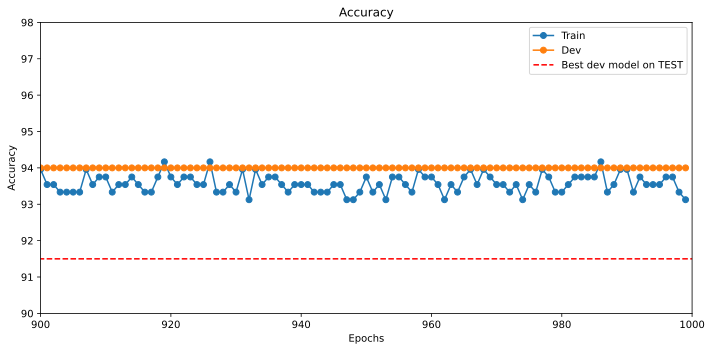

In [ ]:
fig, ax = plt.subplots(1,1,figsize = (10,5))

ax.plot(train_accs, '-o')
ax.plot(dev_accs, '-o')
ax.set_title('Accuracy')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.set_ylim([90,98])
ax.set_xlim([900,1000])
ax.plot([0, len(dev_accs)], [best_acc, best_acc], 'r--')
ax.legend(['Train', 'Dev', 'Best dev model on TEST'])
plt.tight_layout()
plt.show()